In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
#catboost library
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import optuna
#-------------
import warnings
# Set global warning filter
warnings.filterwarnings("ignore")
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*num_leaves.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")

In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv', index_col = 'id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col = 'id')

In [4]:
train_data.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0


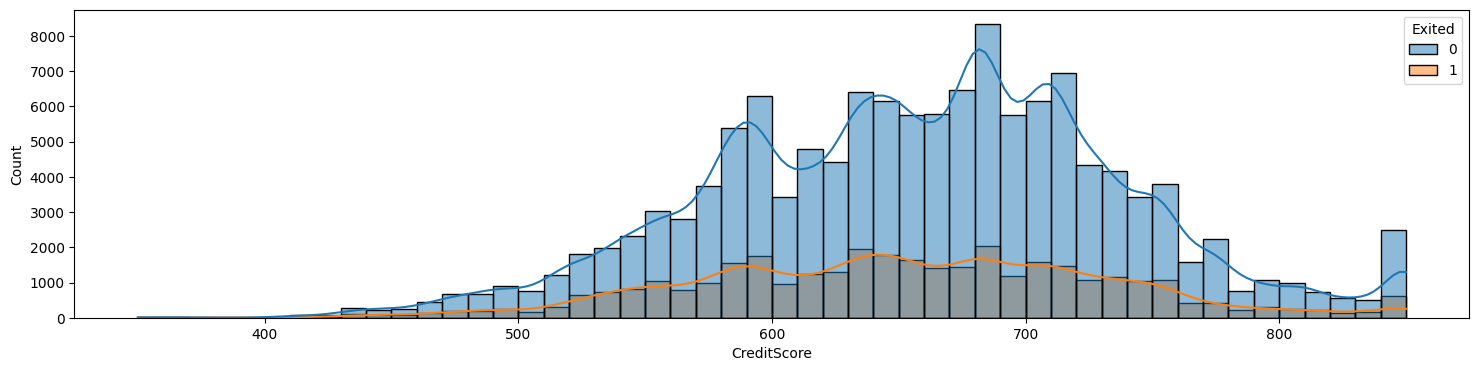

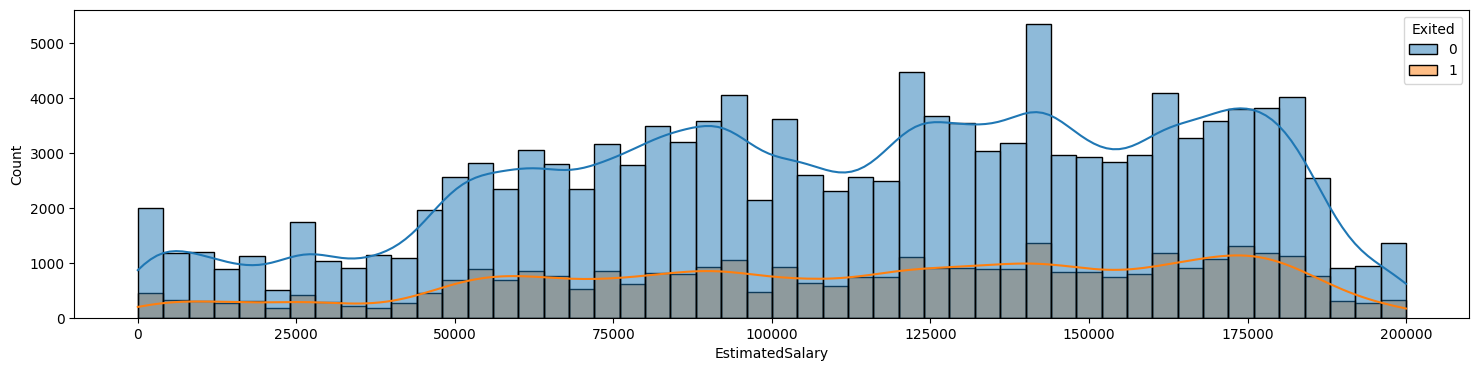

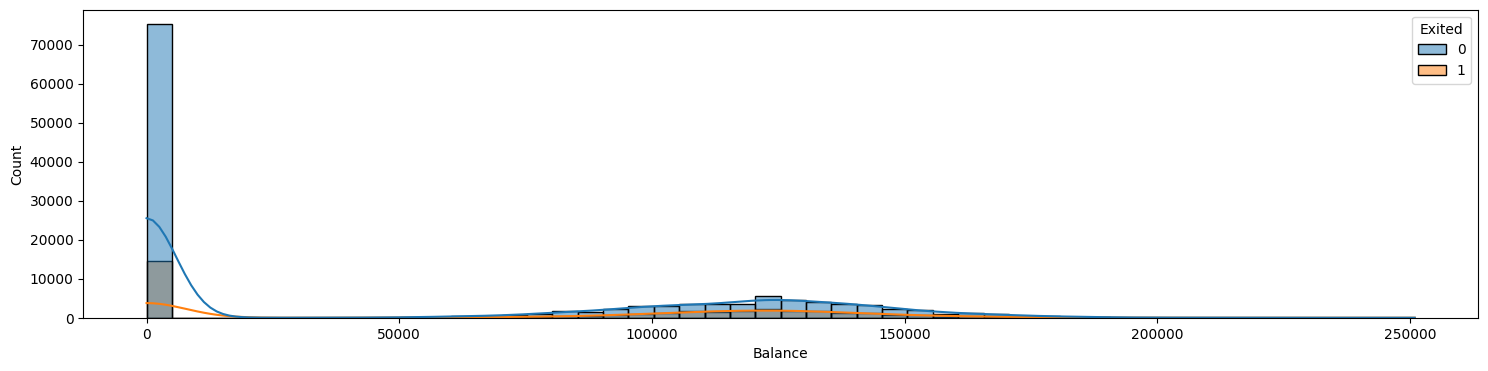

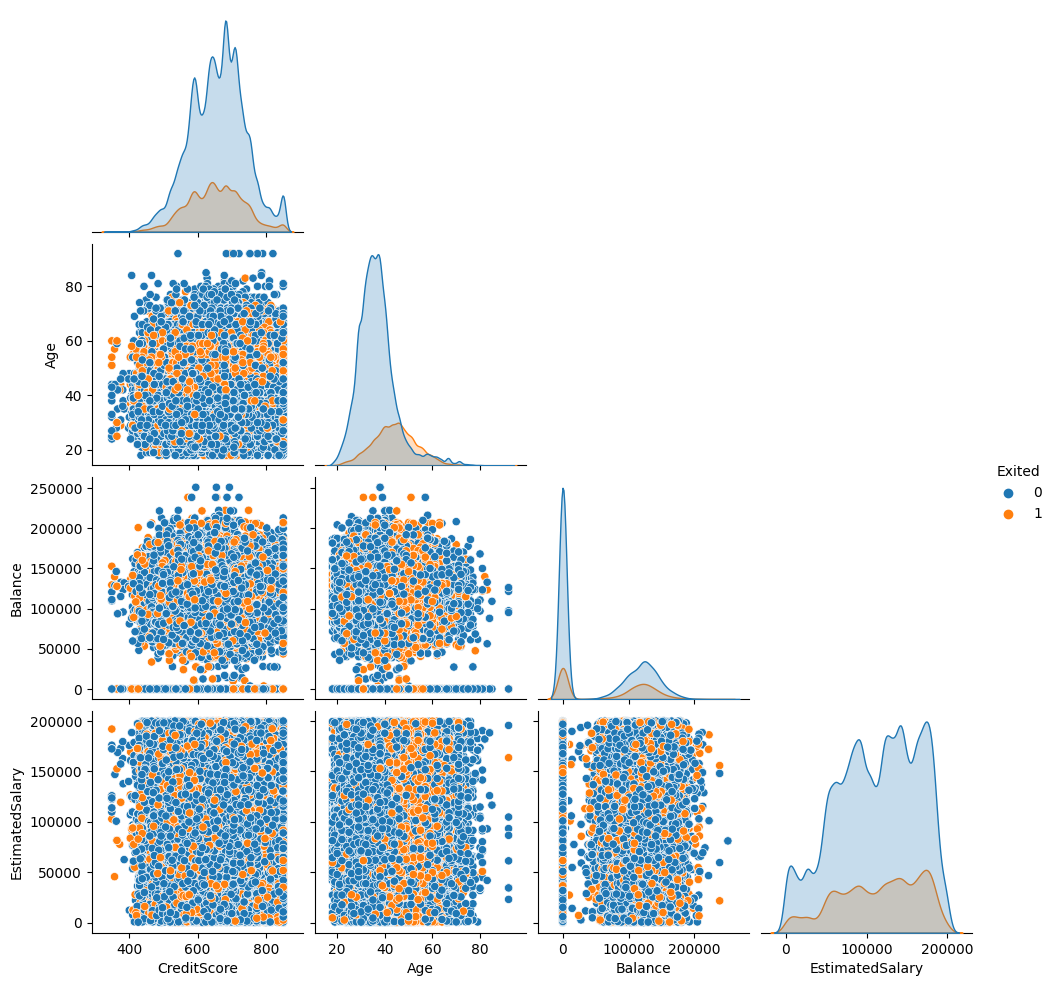

In [5]:
#--------------hist-plot----------------------
continuous_vars = ['CreditScore','EstimatedSalary','Balance']
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()
#--------------pair-plot------------------------    
df = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.pairplot(df, hue="Exited", corner=True)
plt.show()

In [6]:
#0.K—clusters for selected numeric variables
class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_clusters):
        self.columns = columns  # 要进行聚类的列名
        self.n_clusters = n_clusters  # 聚类的数量
        self.kmeans = KMeans(n_clusters=n_clusters)

    def fit(self, X, y=None):
        self.kmeans.fit(X[self.columns])
        return self

    def transform(self, X):
        #print(len(X))
        # 在指定列上进行聚类
        clusters = self.kmeans.predict(X[self.columns])
        # 将聚类结果作为新特征添加到数据集中
        X['Cluster'] = clusters
        #print(len(X))
        return X

In [7]:
#1. SurnameTfidfPca Class
class EnhancedTFIDFPCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features, n_components):
        self.column = column
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.svd = TruncatedSVD(n_components=n_components)

    def fit(self, X, y=None):
        vectors = self.vectorizer.fit_transform(X[self.column])
        self.svd.fit(vectors)
        return self

    def transform(self, X):
        #print(len(X))
        vectors = self.vectorizer.transform(X[self.column])
        svd_result = self.svd.transform(vectors)

        tfidf_df = pd.DataFrame(svd_result, columns=[f"{self.column}_tfidf_{i}" for i in range(self.n_components)], index=X.index)
        #print('tf:',len(tfidf_df))
        X = pd.concat([X, tfidf_df], axis="columns")
        #print(len(X))
        return X
    
#TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5).fit_transform(train) 
    
# tfidf_pca_transformer = EnhancedTFIDFPCATransformer(column="Surname", max_features=1000, n_components=5)

In [8]:

class EncodingData(BaseEstimator, TransformerMixin):
    def __init__(self, scale_cols=None):
        self.scale_cols = scale_cols or ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
        self.scalers = {col: MinMaxScaler() for col in self.scale_cols}

    def fit(self, X, y=None):
        # 对指定的列进行归一化处理的拟合
        for col in self.scale_cols:
            if X[col].dtype != 'object':
                self.scalers[col].fit(X[[col]])
        return self

    def transform(self, X):
        X_copy = X.copy()

        # 应用 LabelEncoder
        label_encoder = LabelEncoder()
        X_copy['Geography'] = label_encoder.fit_transform(X_copy['Geography'])
        X_copy['Gender'] = label_encoder.fit_transform(X_copy['Gender'])

        # 对指定的列进行归一化处理
        for col in self.scale_cols:
            if X_copy[col].dtype != 'object':
                X_copy[col] = self.scalers[col].transform(X_copy[[col]])

        return X_copy

In [9]:
# 3. CreateFeaturesByBinsCut class
class CreateFeaturesByBinsCut(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins_Es=10, n_bins_CS=6):
        self.n_bins_Es = n_bins_Es
        self.n_bins_CS = n_bins_CS

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        salary_bins = pd.cut(X['EstimatedSalary'], bins=self.n_bins_Es, labels=False, right=False)
        CreditScore_bins = pd.cut(X['CreditScore'], bins=self.n_bins_CS, labels=False, right=False)
        X['Salary_binned'] = salary_bins
        X['CreditScore_binned'] = CreditScore_bins
        return X

In [10]:
# 4. AddRatioFeatures class
class AddRatioFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['IsSenior'] = X_copy['Age'].apply(lambda x: 1 if x >= 60 else 0)
        X_copy['IsActive_by_CreditCard'] = X_copy['HasCrCard'] * X_copy['IsActiveMember']
        X_copy['Products_Per_Tenure'] =  X_copy['Tenure'] / X_copy['NumOfProducts']
        X_copy['Balance_Salary_Ratio'] = X_copy['Balance'] / X_copy['EstimatedSalary']
        return X_copy

In [11]:
# 5. DirectBinaryEncoding class
class DirectBinaryEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, feature1, feature2, new_feature_name):
        self.feature1 = feature1
        self.feature2 = feature2
        self.new_feature_name = new_feature_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        print()
        # 填充缺失值或删除缺失值
        X_copy[self.feature1] = X_copy[self.feature1].astype(str).str.replace('.', '', regex=False)
        X_copy[self.feature2] = X_copy[self.feature2].astype(str).str.replace('.', '', regex=False)


        # 确保特征值为字符串
        X_copy[self.feature1] = X_copy[self.feature1].astype(str)
        X_copy[self.feature2] = X_copy[self.feature2].astype(str)

        # 字符串拼接
        combined_str = X_copy[self.feature1] + X_copy[self.feature2]
        # 将拼接后的字符串直接转换为数值
        X_copy[self.new_feature_name] = combined_str.apply(lambda x: int(x) if x.isdigit() else 0)

        # 将数值转换为二进制表示
        X_copy[self.new_feature_name] = X_copy[self.new_feature_name].apply(lambda x: bin(x)[2:])


        return X_copy

In [12]:
# 6. ConvertObjectToInt class
class ConvertObjectToInt(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.columns:
            if X[col].dtype == 'object':
                try:
                    X[col] = X[col].astype(int)
                except ValueError:
                    X[col] = X[col].astype('category').cat.codes
        return X

In [13]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=['Surname_tfidf_0','Surname_tfidf_1','Surname_tfidf_5','Balance_Salary_Ratio','Surname','CustomerId']):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

In [14]:
# 创建 Pipeline
data_process_pipeline = Pipeline([
    ('kmeans_cluster', KMeansClusterer(columns=["EstimatedSalary","Balance",'Age'], n_clusters=8)),
    ('tfidf_pca', EnhancedTFIDFPCATransformer(column="Surname", max_features=1000, n_components=6)),
    ('Encoding_Data', EncodingData()),
    ('create_features', CreateFeaturesByBinsCut()),
    ('add_ratio_features', AddRatioFeatures()),
    ('binary_encoding_1', DirectBinaryEncoding(feature1='NumOfProducts', feature2='HasCrCard', new_feature_name='Total_Products_Used')),
    ('binary_encoding_2', DirectBinaryEncoding(feature1='Geography', feature2='Gender', new_feature_name='Geo_Gender')),
    ('binary_encoding_3', DirectBinaryEncoding(feature1='NumOfProducts', feature2='Gender', new_feature_name='Tp_Gender')),
    ('convert_to_int', ConvertObjectToInt()),
    ('drop', DropColumn()),
])

data_process_pipeline

Pipeline(steps=[('kmeans_cluster',
                 KMeansClusterer(columns=['EstimatedSalary', 'Balance', 'Age'],
                                 n_clusters=8)),
                ('tfidf_pca',
                 EnhancedTFIDFPCATransformer(column='Surname',
                                             max_features=1000,
                                             n_components=6)),
                ('Encoding_Data',
                 EncodingData(scale_cols=['Age', 'CreditScore', 'Balance',
                                          'EstimatedSalary'])),
                ('create_features', CreateFeaturesByBinsCut()),
                ('add_rat...
                                      feature2='HasCrCard',
                                      new_feature_name='Total_Products_Used')),
                ('binary_encoding_2',
                 DirectBinaryEncoding(feature1='Geography', feature2='Gender',
                                      new_feature_name='Geo_Gender')),
                ('binary_encoding_3',
                 DirectBinaryEncoding(feature1='NumOfProducts',
                                      feature2='Gender',
                                      new_feature_name='Tp_Gender')),
                ('convert_to_int', ConvertObjectToInt()),
                ('drop', DropColumn())])




CPU times: user 20.3 s, sys: 4.62 s, total: 25 s
Wall time: 17.8 s


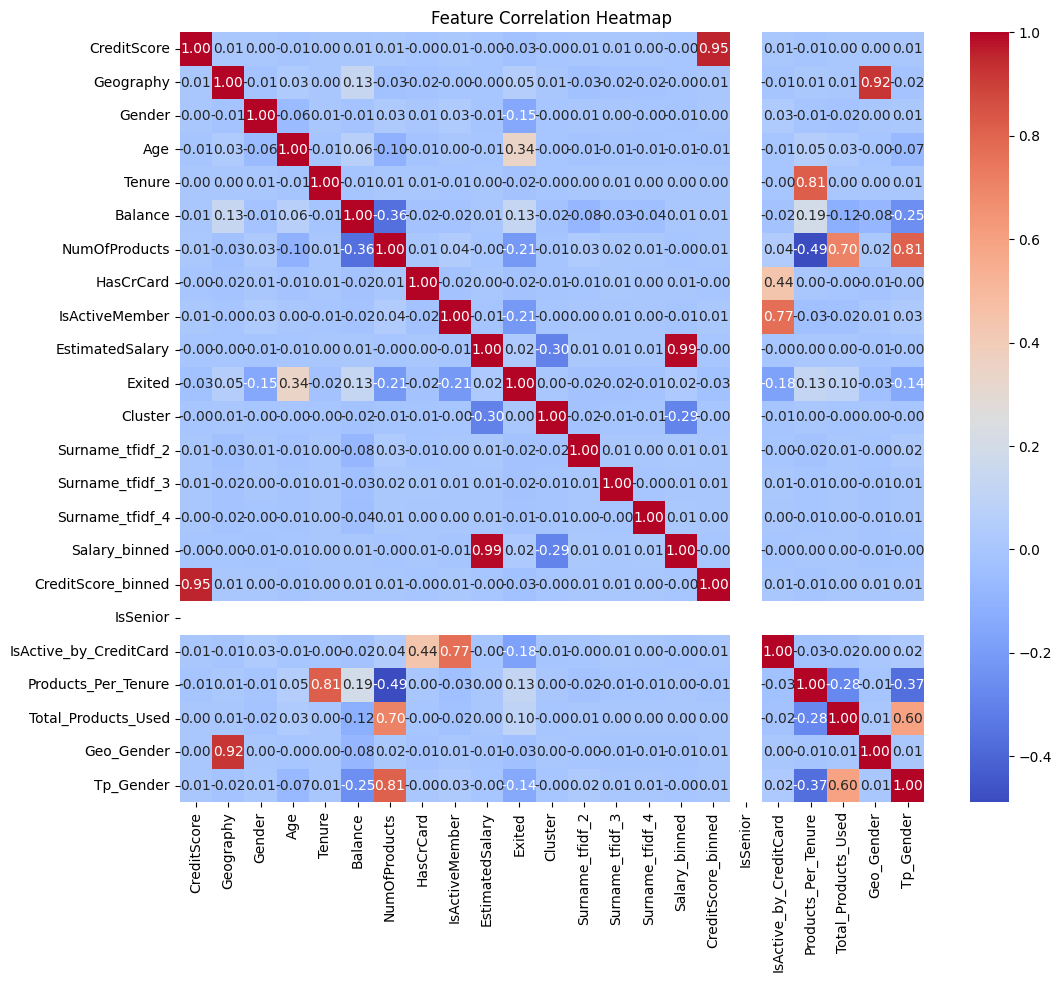

In [15]:
%time df = data_process_pipeline.fit_transform(train_data)
corr_matrix = df.corr()

# 使用 seaborn 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [16]:
# 筛选出与目标变量 'Exited' 相关性较高的特征
target = 'Exited'  # 假设目标变量为 'Exited'
threshold = 0.01  # 设置相关性阈值
corr_matrix[target].sort_values()
low_corr_features = corr_matrix[target][corr_matrix[target].abs() < threshold].index.tolist()

low_corr_features

['Cluster']

In [17]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_tfidf_3,Surname_tfidf_4,Salary_binned,CreditScore_binned,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,Total_Products_Used,Geo_Gender,Tp_Gender
id,,,,,,,,,,,,,,,,,,,,,
0,0.636,0,1,0.202703,3,0.000000,2,10,0.0,0.907279,...,5.321684e-07,-0.000007,9,3,0,0.0,1.5,11010010,1,10101
1,0.554,0,1,0.202703,1,0.000000,2,10,1.0,0.247483,...,-1.123972e-06,0.000003,2,3,0,1.0,0.5,11010010,1,10101
2,0.656,0,1,0.297297,10,0.000000,2,10,0.0,0.924364,...,-2.648509e-03,-0.034173,9,3,0,0.0,5.0,11010010,1,10101
3,0.462,0,1,0.216216,2,0.593398,1,10,1.0,0.422787,...,2.493174e-02,-0.012707,4,2,0,1.0,2.0,1101110,1,1011
4,0.732,2,1,0.202703,5,0.000000,2,10,1.0,0.075293,...,1.740578e-07,0.000002,0,4,0,1.0,2.5,11010010,10101,10101


In [18]:
# 应用 Pipeline
%time train_df = data_process_pipeline.fit_transform(train_data)




CPU times: user 10.2 s, sys: 3.35 s, total: 13.6 s
Wall time: 7.88 s


# 欠采样加训练模型，超参数优化！

In [19]:
def Negative_sample(train):
    majority = train[train['Exited'] == 0]
    minority = train[train['Exited'] == 1]

    # 对多数类别样本进行欠采样
    majority_downsampled = majority.sample(n=3*len(minority), random_state=42)

    # 合并少数类别样本和欠采样后的多数类别样本
    balanced_train = pd.concat([minority, majority_downsampled])
    return balanced_train

train_Nega_sample = Negative_sample(train_df)

In [20]:
def dataset_split(train):
    X = train.drop(['Exited'],axis =1)
    y = train['Exited']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = dataset_split(train_Nega_sample)

In [21]:
def model_fit(X_train, X_test, y_train, y_test):# 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 定义参数网格
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.2, 0.5],
        'max_depth': [3, 4, 5]
    }
    
    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.2, 0.5],
        'num_leaves': [31, 50, 100]
    }
    
    #--------------------------------------------------------------------------
    # 创建 XGBoost 模型
    xgb_model = xgb.XGBClassifier(random_state=42)

    # 创建 GridSearchCV 对象
    xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=2)

    # 拟合 GridSearchCV
    xgb_grid_search.fit(X_train, y_train)
    
    # 使用网格搜索得到的最优参数创建新的 XGBoost 模型
    optimal_xgb_model = xgb.XGBClassifier(**xgb_grid_search.best_params_, random_state=42)

    # 使用训练集训练模型
    optimal_xgb_model.fit(X_train, y_train)

    # 对测试集进行预测
    xgb_predictions = optimal_xgb_model.predict(X_test)

    #--------------------------------------------------------------------------
    # 创建 LightGBM 模型
    lgb_model = lgb.LGBMClassifier(random_state=42)

    # 创建 GridSearchCV 对象
    lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=3, n_jobs=-1, verbose=2)

    # 拟合 GridSearchCV
    lgb_grid_search.fit(X_train, y_train)
    
    # 使用网格搜索得到的最优参数创建新的 XGBoost 模型
    optimal_lgb_model = lgb.LGBMClassifier(**xgb_grid_search.best_params_, random_state=42)

     # 使用训练集训练模型
    optimal_lgb_model.fit(X_train, y_train)

    # 对测试集进行预测
    lgb_predictions = optimal_lgb_model.predict(X_test)   
    
 
    #--------------------------------------------------------------------------
    # 评估模型（例如使用准确率）
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    lgb_accuracy = accuracy_score(y_test, lgb_predictions)
    print("XGBoost Test Accuracy:", xgb_accuracy)
    print("LightGBM Test Accuracy:", lgb_accuracy)
    
    #--------------------------------------------------------------------------
    # 计算混淆矩阵
    cm_xgb = confusion_matrix(y_test, xgb_predictions)

    # 使用 seaborn 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for XGBoost Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    #--------------------------------------------------------------------------
    # 计算混淆矩阵
    cm_lgb = confusion_matrix(y_test, xgb_predictions)

    # 使用 seaborn 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Lgb Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [22]:
 # 定义参数网格
xgb_param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [5]
}

#--------------------------------------------------------------------------
# 创建 XGBoost 模型
xgb_model = xgb.XGBClassifier(random_state=42)

# 创建 GridSearchCV 对象
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=2, n_jobs=-1, verbose=2)

# 拟合 GridSearchCV
xgb_grid_search.fit(X_train, y_train)

# 使用网格搜索得到的最优参数创建新的 XGBoost 模型
optimal_xgb_model = xgb.XGBClassifier(**xgb_grid_search.best_params_, random_state=42)

# 使用训练集训练模型
optimal_xgb_model.fit(X_train, y_train)

# 对测试集进行预测
xgb_predictions = optimal_xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

print("XGBoost Test Accuracy:", xgb_accuracy)

# 计算并打印分类报告
(classification_report(y_test, xgb_predictions))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   3.4s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   3.1s
XGBoost Test Accuracy: 0.8508787629308802


'              precision    recall  f1-score   support\n\n           0       0.87      0.94      0.90     20885\n           1       0.76      0.60      0.67      7052\n\n    accuracy                           0.85     27937\n   macro avg       0.82      0.77      0.79     27937\nweighted avg       0.84      0.85      0.84     27937\n'

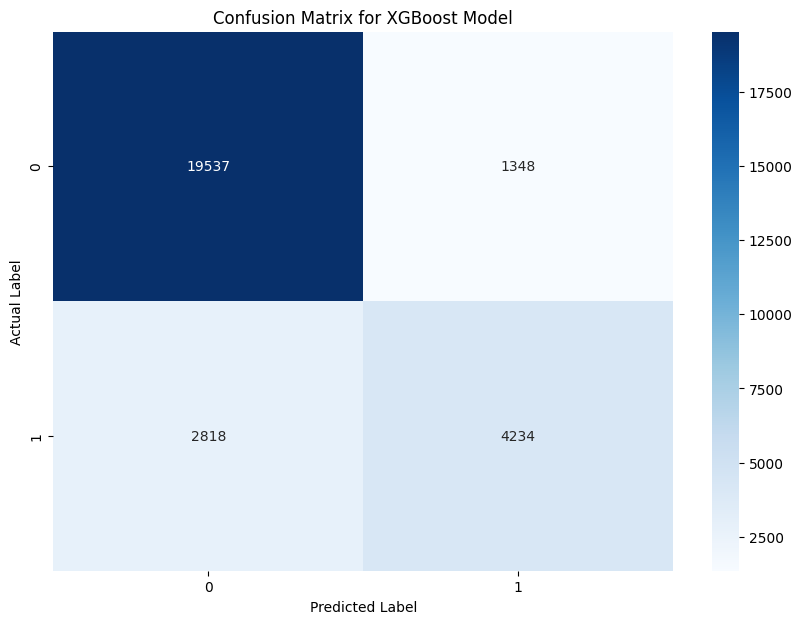

In [23]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, xgb_predictions)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

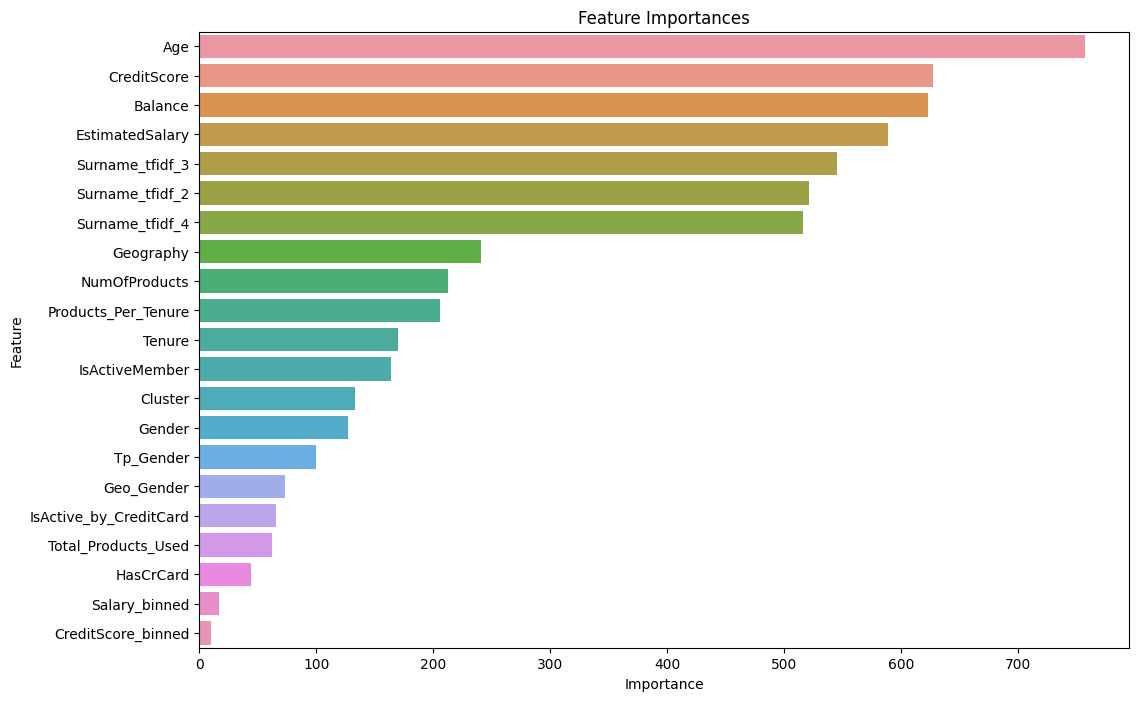

In [24]:
# 获取特征重要性
feature_importances = optimal_xgb_model.get_booster().get_score(importance_type='weight')

# 将特征重要性转换为 DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
})

# 对特征重要性进行排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

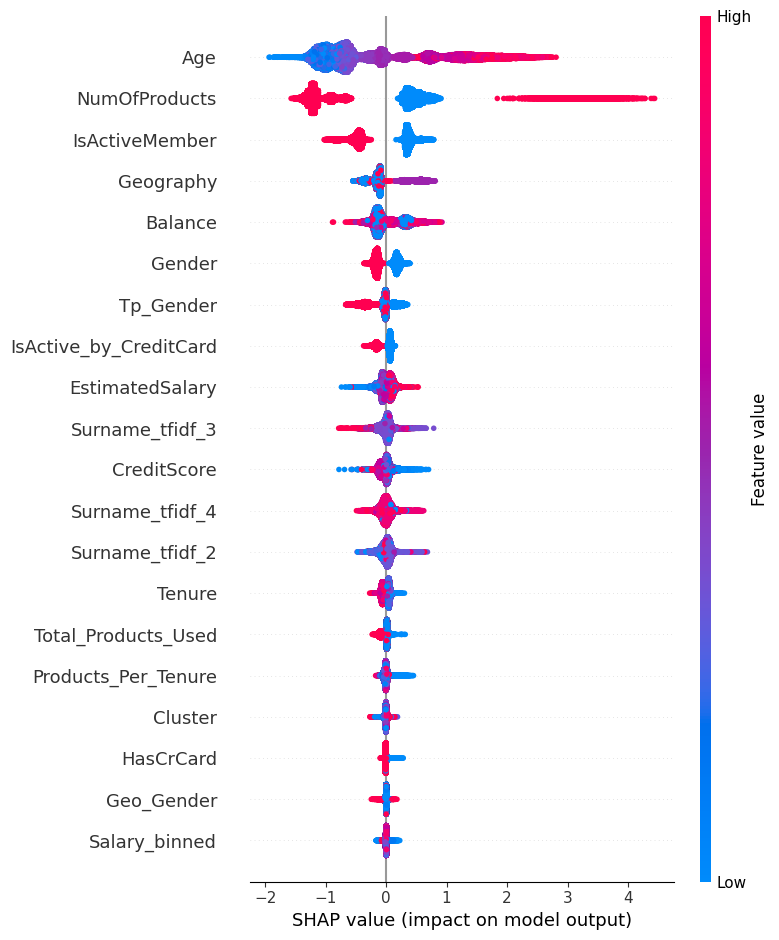

In [25]:
import shap

# 创建一个 SHAP 解释器
explainer = shap.TreeExplainer(optimal_xgb_model)

# 计算 SHAP 值
# 假设 X_train 是您的特征数据
shap_values = explainer.shap_values(X_train)

# 可视化第一个预测的 SHAP 值
# 注意：这是对单个样本的分析
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# 可视化特征重要性
shap.summary_plot(shap_values, X_train)

# 整合pipeline ,生成Voting pipeline

In [26]:
xgb_params_optuna = {'max_depth': 5,
 'min_child_weight': 2, 
 'learning_rate': 0.1,
 'n_estimators': 200, 
 'subsample': 0.8131149969184862,
 'colsample_bytree': 0.6598001508811656,
 'random_state': 42}


# XGBoost model
xgb_model = XGBClassifier(**xgb_params_optuna )

xgb_pipeline = make_pipeline(data_process_pipeline, xgb_model)
xgb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans_cluster',
                                  KMeansClusterer(columns=['EstimatedSalary',
                                                           'Balance', 'Age'],
                                                  n_clusters=8)),
                                 ('tfidf_pca',
                                  EnhancedTFIDFPCATransformer(column='Surname',
                                                              max_features=1000,
                                                              n_components=6)),
                                 ('Encoding_Data',
                                  EncodingData(scale_cols=['Age', 'CreditScore',
                                                           'Balance',
                                                           'EstimatedSalary'])),
                                 ('create_features', CreateFe...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [27]:
#--------------------------------------------
lgbm_params_optuna = {
    'num_leaves': 31, # condition 2^max_depth > num_leaves
    'max_depth': 5, 
    'min_child_samples': 19, 
    'learning_rate': 0.1, 
    'n_estimators': 200, 
    'subsample': 0.7452068722516583, 
    'colsample_bytree': 0.5621023734368561, 
    'reg_alpha': 0.5354115365654548, 
    'reg_lambda': 0.25902660973347336,
    'device': 'gpu',
    'verbosity': 0
} 

# LGBoost model
lgb_model = LGBMClassifier(**xgb_params_optuna )

lgb_pipeline = make_pipeline(data_process_pipeline, lgb_model)
lgb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans_cluster',
                                  KMeansClusterer(columns=['EstimatedSalary',
                                                           'Balance', 'Age'],
                                                  n_clusters=8)),
                                 ('tfidf_pca',
                                  EnhancedTFIDFPCATransformer(column='Surname',
                                                              max_features=1000,
                                                              n_components=6)),
                                 ('Encoding_Data',
                                  EncodingData(scale_cols=['Age', 'CreditScore',
                                                           'Balance',
                                                           'EstimatedSalary'])),
                                 ('create_features', CreateFe...
                                                       new_feature_name='Geo_Gender')),
                                 ('binary_encoding_3',
                                  DirectBinaryEncoding(feature1='NumOfProducts',
                                                       feature2='Gender',
                                                       new_feature_name='Tp_Gender')),
                                 ('convert_to_int', ConvertObjectToInt()),
                                 ('drop', DropColumn())])),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.6598001508811656,
                                max_depth=5, min_child_weight=2,
                                n_estimators=200, random_state=42,
                                subsample=0.8131149969184862))])

In [28]:
#catboost parameters
catboost_params_1 = {
    'iterations': 848, 
    'depth': 28,
    'min_data_in_leaf': 5,
    'learning_rate': 0.027876808218320774,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'eval_metric': 'AUC',  
}

cb_model = CatBoostClassifier(**catboost_params_1, random_state=42, verbose=0)

cb_pipeline = make_pipeline(data_process_pipeline, cb_model)
cb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans_cluster',
                                  KMeansClusterer(columns=['EstimatedSalary',
                                                           'Balance', 'Age'],
                                                  n_clusters=8)),
                                 ('tfidf_pca',
                                  EnhancedTFIDFPCATransformer(column='Surname',
                                                              max_features=1000,
                                                              n_components=6)),
                                 ('Encoding_Data',
                                  EncodingData(scale_cols=['Age', 'CreditScore',
                                                           'Balance',
                                                           'EstimatedSalary'])),
                                 ('create_features', CreateFe...
                                  DirectBinaryEncoding(feature1='Geography',
                                                       feature2='Gender',
                                                       new_feature_name='Geo_Gender')),
                                 ('binary_encoding_3',
                                  DirectBinaryEncoding(feature1='NumOfProducts',
                                                       feature2='Gender',
                                                       new_feature_name='Tp_Gender')),
                                 ('convert_to_int', ConvertObjectToInt()),
                                 ('drop', DropColumn())])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7d32616c21d0>)])

In [29]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_pipeline), 
        ('lgbM', lgb_pipeline),
        ('cb', cb_pipeline)
    ], 
    voting='soft', 
    weights = [0.3,0.3,0.4]
)
voting_clf

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('kmeans_cluster',
                                                                KMeansClusterer(columns=['EstimatedSalary',
                                                                                         'Balance',
                                                                                         'Age'],
                                                                                n_clusters=8)),
                                                               ('tfidf_pca',
                                                                EnhancedTFIDFPCATransformer(column='Surname',
                                                                                            max_features=1000,
                                                                                            n_components=6)),
                                                               ('Encoding_Data',
                                                                EncodingData(scale_cols=['Age',
                                                                                         'CreditScore',
                                                                                         'Balance',
                                                                                         'EstimatedSa...
                                                                                     feature2='Gender',
                                                                                     new_feature_name='Geo_Gender')),
                                                               ('binary_encoding_3',
                                                                DirectBinaryEncoding(feature1='NumOfProducts',
                                                                                     feature2='Gender',
                                                                                     new_feature_name='Tp_Gender')),
                                                               ('convert_to_int',
                                                                ConvertObjectToInt()),
                                                               ('drop',
                                                                DropColumn())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7d32616c21d0>)]))],
                 voting='soft', weights=[0.3, 0.3, 0.4])

In [30]:
# Fit the ensemble final model
%time voting_clf.fit(X=train_data.drop(['Exited'], axis=1), y=train_data['Exited'])










CPU times: user 3min 42s, sys: 23.6 s, total: 4min 6s
Wall time: 1min 27s


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('kmeans_cluster',
                                                                KMeansClusterer(columns=['EstimatedSalary',
                                                                                         'Balance',
                                                                                         'Age'],
                                                                                n_clusters=8)),
                                                               ('tfidf_pca',
                                                                EnhancedTFIDFPCATransformer(column='Surname',
                                                                                            max_features=1000,
                                                                                            n_components=6)),
                                                               ('Encoding_Data',
                                                                EncodingData(scale_cols=['Age',
                                                                                         'CreditScore',
                                                                                         'Balance',
                                                                                         'EstimatedSa...
                                                                                     feature2='Gender',
                                                                                     new_feature_name='Geo_Gender')),
                                                               ('binary_encoding_3',
                                                                DirectBinaryEncoding(feature1='NumOfProducts',
                                                                                     feature2='Gender',
                                                                                     new_feature_name='Tp_Gender')),
                                                               ('convert_to_int',
                                                                ConvertObjectToInt()),
                                                               ('drop',
                                                                DropColumn())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7d32616c21d0>)]))],
                 voting='soft', weights=[0.3, 0.3, 0.4])

In [31]:
predictions = voting_clf.predict_proba(test_data)[:, 1]  # Use the probabilities of class 1

In [32]:
results = pd.DataFrame({
    'id': test_data.index,
    'Exited': predictions
})

results.to_csv('Final_Submission4.csv', index=False)

In [33]:
results

,id,Exited
0,165034,0.022096
1,165035,0.726498
2,165036,0.036392
3,165037,0.232527
4,165038,0.419326
...,...,...
110018,275052,0.033196
110019,275053,0.149812
110020,275054,0.012528
110021,275055,0.162699
